In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

In [2]:
data = pd.read_csv('data/Hitters.csv').dropna()
data

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [3]:
hitters = pd.get_dummies(data, columns=['League', 'Division', 'NewLeague'], drop_first=True)
hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3,700.0,1,0,1
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20,875.0,0,0,0
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7,385.0,0,1,0
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12,960.0,0,0,0


In [4]:
# Split X, y
X = hitters.drop(columns='Salary')
y = hitters['Salary']

# Set range of alpha
alphas = np.logspace(4, -4, 100)

In [5]:
# Create Function Ridge or Lasso
def result_model(model, alphas, X, y):

    # Choose model
    if model == 'ridge':
        lm = Ridge(normalize= True)
    else:
        lm = Lasso(normalize= True)

    coefs = []

    # Run all model on range alphas
    for a in alphas:
        lm.set_params(alpha = a)
        lm.fit(X, y)
        coefs.append(lm.coef_)

    # Wrap in data frame with Collums names
    results = pd.DataFrame(coefs, columns=X.columns)
    
    return results

In [6]:
result_ridge = result_model('ridge', alphas, X, y)
result_lasso = result_model('lasso', alphas, X, y)

In [7]:
# Split data in train-test sample multiple time to compute MSE for choosing best k and receive best feature for model
def mse(model, alphas, X, y, n_times):
    # Create array to store mse mean each alpha
    mse_mean = np.array([])

    # Choose model: Ridge or Lasso
    if model == 'ridge':
        lm = Ridge(normalize=True)
    else:
        lm = Lasso(normalize=True)

    # Run model on range of alphas with the K_fold cross validation
    for a in alphas:
        lm.set_params(alpha = a)
        mse = []

        # K_fold cross validation to create train_test
        cv = KFold(n_splits=n_times, random_state=None, shuffle=False)
        for train_index, test_index in cv.split(X):

            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_test, y_test = X.iloc[test_index], y.iloc[test_index]

            # Fit model
            model = lm.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Calculate mse & append to list
            mse.append(mean_squared_error(y_test, y_pred))

        # Store to array
        mse_mean = np.append(mse_mean, np.mean(mse))

    return mse_mean

In [8]:
mse_ridge = mse('ridge', alphas, X, y, 10)
mse_lasso = mse('lasso', alphas, X, y, 10)
optimal_alpha_ridge = alphas[mse_ridge.argmin()]
optimal_alpha_lasso = alphas[mse_lasso.argmin()]

In [9]:
def display_model(result_model, model, optimal_alpha):

    # Create threshold k where reduce significant coef beta
    if model == 'ridge':
        optimal_coef = Ridge(normalize=True).set_params(alpha = optimal_alpha).fit(X, y).coef_
    else:
        optimal_coef = Lasso(normalize=True).set_params(alpha = optimal_alpha).fit(X, y).coef_

    # Draw all feature coef of model
    for i in range(len(result_model.columns)):
        label = '{}  : {:.2f}'.format(result_model.columns[i], optimal_coef[i]) if np.abs(optimal_coef[i])> 0.05 else ''
        plt.plot(alphas, result_model.iloc[:,i], linewidth=3, label=label)

    # Draw a vertical line at threshold k
    plt.axvline(x=optimal_alpha, linestyle='--', linewidth=2, label='Optimal alpha : {:.2f}'.format(optimal_alpha))

    # Scale in log for easier to see, set x,ylabel, legend
    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('Standardized Coef')
    plt.legend()

In [54]:
def display_mse(mse_result):

    # Plot MSE line
    plt.plot(alphas, mse_result, label='MSE')

    # Plot Min point
    plt.scatter(alphas[mse_result.argmin()], mse_result.min(), label='Min MSE: {:,.0f} at alpha: {:.2f}'.format(mse_result.min(), alphas[mse_result.argmin()]))
    plt.xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('Mean Squared Error')
    plt.legend()

In [55]:
def display_number_predictors_by_alpha(result_model, optimal_alpha):
    # Calculate number predictors follow by changes of alpha
    number_predictors = result_model.astype('bool').sum(axis=1)

    # Plot line, and optimal alpha
    plt.plot(alphas, number_predictors, label='Number Predictors')
    plt.axvline(x=optimal_alpha, linestyle='--', linewidth=2, label='Optimal alpha : {:.2f}'.format(optimal_alpha))

    plt.xscale('log')
    plt.yticks(np.arange(0,len(result_model.columns)+1))
    plt.legend()

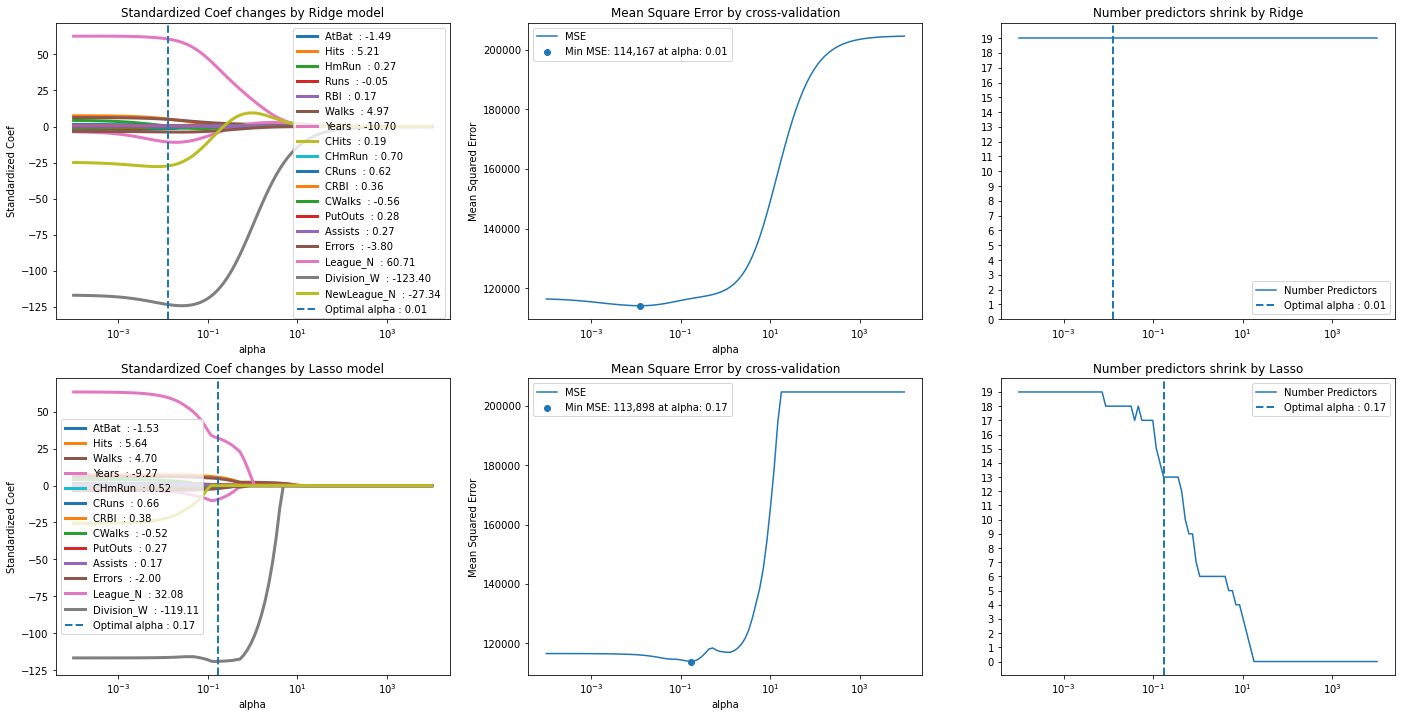

In [56]:
plt.figure(figsize=(24,12))

plot_1 = plt.subplot(2,3,1)
display_model(result_ridge, 'ridge', optimal_alpha_ridge)
plt.title('Standardized Coef changes by Ridge model')

plot_2 = plt.subplot(2,3,2)
display_mse(mse_ridge)
plt.title('Mean Square Error by cross-validation')

plot_3 = plt.subplot(2,3,3)
display_number_predictors_by_alpha(result_ridge, optimal_alpha_ridge)
plt.title('Number predictors shrink by Ridge')

plot_4 = plt.subplot(2,3,4)
display_model(result_lasso, 'lasso', optimal_alpha_lasso)
plt.title('Standardized Coef changes by Lasso model')

plot_5 = plt.subplot(2,3,5)
display_mse(mse_lasso)
plt.title('Mean Square Error by cross-validation')

plot_6 = plt.subplot(2,3,6)
display_number_predictors_by_alpha(result_lasso, optimal_alpha_lasso)
plt.title('Number predictors shrink by Lasso')

plt.show()

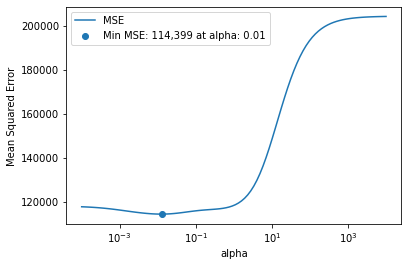

In [57]:
# Run Ridge CV to calculate mse and identify best alpha
ridgecv = RidgeCV(alphas=alphas, normalize=True, store_cv_values=True).fit(X, y)
mse_ridge_cv = ridgecv.cv_values_.mean(axis=0)
optimal_alpha_ridge_cv = ridgecv.alpha_
display_mse(mse_ridge_cv)

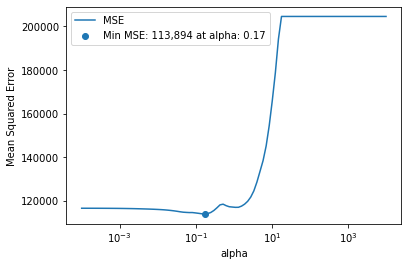

In [58]:
# Run Lasso CV to calculate mse and identify best alpha
lassocv = LassoCV(alphas=alphas, normalize=True, cv=10).fit(X, y)
mse_lasso_cv = lassocv.mse_path_.mean(axis=1)
optimal_alpha_lasso_cv = lassocv.alpha_
display_mse(mse_lasso_cv)